In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-dys/anonimyzed_data - Risposte del modulo 1.csv
/kaggle/input/data-dys/italy.csv
/kaggle/input/data-dys/anonimyzed_data - Module 1 answers.csv
/kaggle/input/data-dys/anonimyzed_data - Risp_Pulite.csv
/kaggle/input/data-dys/values.csv


In [2]:
!pip install wandb --quiet

In [3]:
import numpy as np
import pandas as pd
import torch.optim as optim
import os
import requests
import zipfile
from pathlib import Path
import torch
import random
import wandb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
import optuna

In [4]:
wandb.__version__

'0.18.3'

In [5]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def read_data():
    df = pd.read_csv('/kaggle/input/data-dys/values.csv') 
    df = df.stack().rename_axis(('User', 'Item')).reset_index(name='Score') # df with User and Items as columns and Score as the values
    item_labels, item_original = pd.factorize(df['Item']) # Label encoding and storing original labels
    df['Item'] = item_labels # encoded lables assigned
    df = df.sample(n=len(df))
    df.replace(' ', 0, inplace=True) # Replaces empty values with 0
    df.replace('NC', 0, inplace=True) # Replaces NC values with 0
    df.replace('NSU', 0, inplace=True) # Replaces NSU values with 0
    print(df.isnull().sum()) # sum of all null values
    df['Score'] = df['Score'].astype(int)
    df = df[df['Score'] != 0] # removing values that are 0
    num_users = len(df.User.unique()) # count of users
    num_items = len(df.Item.unique()) # count of items
    return df, num_users, num_items, item_original

cuda


In [7]:
def split_data(data, test_ratio):
  """
   Splits input data into training and test sets.

   Args:
       data: Input dataset to split
       test_ratio: Proportion of data to use for testing (between 0 and 1)

   Returns:
       tuple: (train_data, test_data) containing the split datasets
  """
  train_data, test_data = train_test_split(data, test_size=test_ratio, random_state=42) # data splitting
  return train_data, test_data

In [8]:
def load_data(data, num_users, num_items, feedback='explicit'):
    """
    Processes rating/interaction data into separate lists of users, items, and scores.
    Also creates a dictionary mapping users to their interacted items.

    Args:
        data: DataFrame containing user-item interaction data
        num_users: Total number of unique users in the dataset
        num_items: Total number of unique items in the dataset
        feedback: Type of feedback - 'explicit' for ratings, otherwise implicit (binary)

    Returns:
        users: List of user indices
        items: List of item indices
        scores: List of interaction scores/ratings
        inter: Dictionary mapping each user to list of items they interacted with
    """
    users, items, scores = [], [], []
    inter = {}
    for line in data.itertuples():
        user_index, item_index = int(line[1]), int(line[2]) #  Extract user and item indices from current row
        score = int(line[3]) if feedback == 'explicit' else 1 # Store values of scores for each item user combination
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        inter.setdefault(user_index, []).append(item_index)
    return users, items, scores, inter

In [9]:
class PRDataset(Dataset):
    """
    Custom PyTorch Dataset for Personalized Ranking that generates positive and negative item samples.
    Implements negative sampling by randomly selecting items a user hasn't interacted with.

    Args:
        users: List of user indices
        items: List of item indices (positive interactions)
        candidates: Dictionary mapping users to their interacted items
        num_items: Total number of items in the dataset
    """
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates # Store mapping of users to their interacted items
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        """
        Returns the total number of user-item interactions in the dataset
        """
        return len(self.users)

    def __getitem__(self, idx):
        """
        Retrieves a training sample consisting of (user, positive_item, negative_item)

        Args:
            idx: Index of the interaction to retrieve

        Returns:
            tuple: (user_index, positive_item_index, negative_item_index)
            - negative_item is randomly sampled from items the user hasn't interacted with
      """
        neg_items = list(self.all - set(self.cand[int(self.users[idx])])) # Get set of items the user hasn't interacted with (negative items)
        indices = random.randint(0, len(neg_items) - 1) # Randomly select one negative item
        return self.users[idx], self.items[idx], neg_items[indices]  # Return user index, positive item index, and sampled negative item index

In [10]:
class NeuMF(nn.Module):
    """
    Neural Matrix Factorization (NeuMF) model that combines Matrix Factorization (MF)
    and Multi-Layer Perceptron (MLP) for recommendation.

    Args:
        num_factors: Dimension of the embedding vectors
        num_users: Total number of users in the dataset
        num_items: Total number of items in the dataset
        nums_hiddens: List of hidden layer sizes for the MLP component
  """
    def __init__(self, num_factors, num_users, num_items, nums_hiddens):
        super(NeuMF, self).__init__()
        # Embeddings for Matrix Factorization component
        self.P = nn.Embedding(num_users, num_factors) # User embeddings for MF
        self.Q = nn.Embedding(num_items, num_factors) # Item embeddings for MF
        # Embeddings for MLP component
        self.U = nn.Embedding(num_users, num_factors) # User embeddings for MLP
        self.V = nn.Embedding(num_items, num_factors) # Item embeddings for MLP
        mlp_layers = []
        input_size = num_factors * 2 # Concatenated user and item embeddings
        for num_hiddens in nums_hiddens:
            mlp_layers.append(nn.Linear(input_size, num_hiddens))
            mlp_layers.append(nn.ReLU())
            input_size = num_hiddens
        mlp_layers.append(nn.Dropout(0.2))
        self.mlp = nn.Sequential(*mlp_layers)
        self.prediction_layer = nn.Linear(num_factors + nums_hiddens[-1], 1)
        # self.sigmoid = nn.Sigmoid()

    def _init_weights(self):
        """
        Initialize model weights using Xavier uniform initialization
      """
      # Initialize embedding layers
        nn.init.xavier_uniform_(self.P.weight)
        nn.init.xavier_uniform_(self.Q.weight)
        nn.init.xavier_uniform_(self.U.weight)
        nn.init.xavier_uniform_(self.V.weight)

      # Initialize MLP layers
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

      # Initialize prediction layer
        nn.init.xavier_uniform_(self.prediction_layer.weight)
        nn.init.zeros_(self.prediction_layer.bias)

    def forward(self, user_id, item_id):
        """
        Forward pass of the model

        Args:
            user_id: Tensor of user indices
            item_id: Tensor of item indices

        Returns:
            prediction: Predicted ratings/scores for the user-item pairs
      """
      # Matrix Factorization part
        p_mf = self.P(user_id) # Get user embeddings for MF
        q_mf = self.Q(item_id) # Get item embeddings for MF
        gmf = p_mf * q_mf # Element-wise product for MF

        # MLP part
        p_mlp = self.U(user_id) # Get user embeddings for MLP
        q_mlp = self.V(item_id) # Get item embeddings for MLP
        mlp_input = torch.cat([p_mlp, q_mlp], dim=1) # Concatenate embeddings
        mlp_output = self.mlp(mlp_input) # Pass through MLP layers

        # Combine MF and MLP outputs
        concat = torch.cat([gmf, mlp_output], dim=1)
        prediction = self.prediction_layer(concat)
        return prediction

In [11]:
def hit_and_auc(rankedlist, test_matrix, k):
    """
    Calculates Hit Rate@K and AUC for a ranked list of recommendations.

    Args:
        rankedlist: List of items sorted by predicted scores
        test_matrix: Ground truth items the user interacted with
        k: Number of top items to consider for Hit Rate

    Returns:
        tuple: (hit_rate@k, auc) metrics
    """
    # Find hits among top-k recommendations
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]

    # Find all hits in the complete ranked list
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    # Calculate maximum possible rank position
    max = len(rankedlist) - 1

    # Calculate AUC based on position of first hit
    # AUC = 1 - (first_hit_position / max_position)
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0

    # Calculate Hit Rate@k (number of hits in top-k / k)
    return len(hits_k) / k, auc

In [12]:
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items, device, batch_size, top_k=5):
    """
    Evaluates a recommendation model using ranking metrics (Hit Rate and AUC).

    Args:
        net: The trained recommendation model
        test_input: Dictionary mapping users to their test items
        seq: Sequential data (optional) for sequential recommendation models
        candidates: Dictionary of items each user has interacted with
        num_users: Total number of users
        num_items: Total number of items
        device: Device to run computations on (CPU/GPU)
        batch_size: Batch size for evaluation
        top_k: Number of top items to consider for Hit Rate calculation

    Returns:
        tuple: (mean_hit_rate, mean_auc) across all test users
  """
    # Initialize dictionaries to store rankings and metrics
    ranked_list = {}    # Stores (item, score) pairs for each user
    ranked_items = {}   # Stores ordered items for each user
    hit_rate = []      # Stores hit rate for each test user
    auc = []           # Stores AUC for each test user

    # Get set of all possible items
    all_items = set([i for i in range(num_items)])

    # Evaluate each user
    for u in range(num_users):
      # Get items the user hasn't interacted with (negative items)
        neg_items = list(all_items - set(candidates[int(u)]))

      # Create input tensors for prediction
        user_ids = [u] * len(neg_items)
        item_ids = neg_items
        x = [torch.tensor(user_ids, device=device), torch.tensor(item_ids, device=device)] #create user, items pairs

      # Add sequential data if provided
        if seq is not None:
            x.append(seq[user_ids, :].to(device))

      # Create DataLoader for batch processing
        test_data_iter = torch.utils.data.DataLoader(
            dataset=list(zip(*x)), batch_size=batch_size, shuffle=False # create a dictionary of user and items
        )

       # Get predictions for all negative items
        scores = []
        for batch in test_data_iter:
            user_batch, item_batch = batch[0].to(device), batch[1].to(device)
            if seq is not None: # Set to None
                seq_batch = batch[2].to(device)
                batch_scores = net(user_batch, item_batch, seq_batch).cpu().detach().numpy()
            else:
                batch_scores = net(user_batch, item_batch).cpu().detach().numpy()
            scores.extend(batch_scores)

      # Create and sort (item, score) pairs
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]

      # Skip users not in test set
        if u not in test_input:
            continue

      # Calculate Hit Rate and AUC for test users
        hit, auc_val = hit_and_auc(ranked_items[u], test_input[u], top_k)
        hit_rate.append(hit)
        auc.append(auc_val)

    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [13]:
from tqdm.auto import tqdm
def train_ranking(net, train_iter, test_iter, loss_fn, optimizer, test_seq_iter, num_users, num_items, num_epochs, device, evaluator,
                  candidates, batch_size, top_k, eval_step=1):
    """
    Trains a ranking-based recommendation model using BPR loss.

    Args:
        net: The recommendation model to train
        train_iter: Training data iterator (user, positive item, negative item)
        test_iter: Test data for evaluation
        loss_fn: Loss function (typically BPR loss)
        optimizer: Optimizer for model parameters
        test_seq_iter: Sequential data for testing (optional)
        num_users: Total number of users
        num_items: Total number of items
        num_epochs: Number of training epochs
        device: Device to run training on (CPU/GPU)
        evaluator: Evaluation function
        candidates: Dictionary of items each user has interacted with
        batch_size: Batch size for evaluation
        top_k: Number of top items for Hit Rate calculation
        eval_step: Frequency of evaluation (epochs)

    Returns:
        tuple: Lists containing (hit_rates, auc_scores, training_losses)
  """
   # Initialize lists to track metrics
    loss_l, hit_l, auc_l = [], [], []

    # Training loop over epochs
    for epoch in tqdm(range(num_epochs)):
      # Initialize epoch statistics
        total_loss, num_examples, num_batches = 0.0, 0, 0
        # Set model to training mode
        net.train()
        for i, values in enumerate(train_iter):
          # Move batch data to device
            input_data = [v.to(device) for v in values]

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass for positive and negative items
            p_pos = net(input_data[0], input_data[1])
            p_neg = net(input_data[0], input_data[2])

            # Calculate BPR loss
            loss = loss_fn(p_pos, p_neg)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss statistics
            total_loss += loss.item() * input_data[0].size(0)
            num_examples += input_data[0].size(0)
            num_batches += 1
        # scheduler.step()

      # Evaluation phase
        if (epoch + 1) % eval_step == 0:
            net.eval()

            # Evaluate model without gradient computation
            with torch.no_grad():
                hit_rate, auc = evaluate_ranking(net, test_iter, test_seq_iter, candidates, num_users, num_items, device, batch_size, top_k)
            print(f'Epoch {epoch + 1}, Hit Rate: {hit_rate:.3f}, AUC: {auc:.3f}', end = ' ')
            hit_l.append(hit_rate)
            auc_l.append(auc)
            
        avg_loss = total_loss / num_examples
        print(f'Training Loss: {avg_loss:.3f}', end='\n')
        loss_l.append(avg_loss)

    return hit_l, auc_l, loss_l

User     0
Item     0
Score    0
dtype: int64
NeuMF(
  (P): Embedding(1216, 512)
  (Q): Embedding(51, 512)
  (U): Embedding(1216, 512)
  (V): Embedding(51, 512)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): ReLU()
    (14): Linear(in_features=8, out_features=4, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.2, inplace=False)
  )
  (prediction_layer): Linear(in_features=516, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.658, AUC: 0.965 Training Loss: 0.706
Epoch 2, Hit Rate: 0.664, AUC: 0.967 Training Loss: 0.683
Epoch 3, Hit Rate: 0.662, AUC: 0.963 Training Loss: 0.668
Epoch 4, Hit Rate: 0.663, AUC: 0.964 Training Loss: 0.649
Epoch 5, Hit Rate: 0.675, AUC: 0.964 Training Loss: 0.617
Epoch 6, Hit Rate: 0.699, AUC: 0.968 Training Loss: 0.574
Epoch 7, Hit Rate: 0.733, AUC: 0.975 Training Loss: 0.512
Epoch 8, Hit Rate: 0.773, AUC: 0.981 Training Loss: 0.440
Epoch 9, Hit Rate: 0.791, AUC: 0.984 Training Loss: 0.368
Epoch 10, Hit Rate: 0.806, AUC: 0.986 Training Loss: 0.301
Epoch 11, Hit Rate: 0.799, AUC: 0.984 Training Loss: 0.245
Epoch 12, Hit Rate: 0.800, AUC: 0.985 Training Loss: 0.198
Epoch 13, Hit Rate: 0.802, AUC: 0.985 Training Loss: 0.162
Epoch 14, Hit Rate: 0.802, AUC: 0.987 Training Loss: 0.136
Epoch 15, Hit Rate: 0.796, AUC: 0.984 Training Loss: 0.116
Epoch 16, Hit Rate: 0.786, AUC: 0.984 Training Loss: 0.102
Epoch 17, Hit Rate: 0.790, AUC: 0.984 Training Loss: 0.090
Epoch 

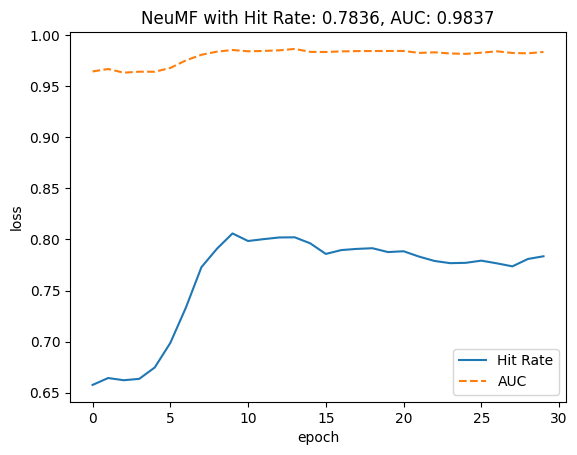

In [14]:
# Set batch size for training
batch_size = 512 #1024

# Load and preprocess data
df, num_users, num_items, item_original = read_data()
train_data, test_data = split_data(df, 0.25)

# Process training data
users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")

# Process test data
users_test, items_test, ratings_test, test_iter = load_data(test_data, num_users, num_items, feedback="explicit")

# Create dataset for personalized ranking
train_dataset = PRDataset(users_train, items_train, candidates, num_items)

# Create DataLoader with parallel data loading
train_iter = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

# Initialize Neural Matrix Factorization model
set_seeds()
net = NeuMF(num_factors= 512, num_users=num_users, num_items=num_items, nums_hiddens=[512, 256, 128, 64, 32, 16, 8, 4])
print(net)
net = net.to(device)

lr = 3.202e-3
num_epochs = 30
weight_decay = 9.116e-5

# Initialize optimizer with Adam
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

# Learning rate scheduler - reduce LR by 10x every 10 epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


class BPRLoss(nn.Module):
    """
    Bayesian Personalized Ranking loss for implicit feedback.
    Optimizes for correct ranking between positive and negative items.
  """
    def __init__(self):
        super(BPRLoss, self).__init__()

    def forward(self, pos_preds, neg_preds):
        return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

loss_fn = BPRLoss()

# Train the model
top_k = 5
hit, auc, loss = train_ranking(
    net=net,
    train_iter=train_iter,
    test_iter=test_iter,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_seq_iter=None,
    num_users=num_users,
    num_items=num_items,
    num_epochs=num_epochs,
    device=device,
    candidates=candidates,
    batch_size=batch_size,
    top_k=top_k,
    evaluator=evaluate_ranking,
)

# Plot training results
plt.plot(hit)
plt.plot(auc, '--')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title(f'NeuMF with Hit Rate: {hit[-1]:.4f}, AUC: {auc[-1]:.4f}')
plt.legend(['Hit Rate', 'AUC'])

In [15]:
print(f'Hit Rate@{top_k} is {hit[-1]:.3f} AUC is {auc[-1]:.3f}')

Hit Rate@5 is 0.784 AUC is 0.984


In [16]:
def show_random_prediction(user, net, test_data, num_users, num_items, candidates, top_k, device):
    """
   Shows top-k recommendations for a specific user.

   Args:
       user: User ID to generate recommendations for
       net: Trained recommendation model
       test_data: Test dataset
       num_users: Total number of users
       num_items: Total number of items
       candidates: Dictionary of items each user has interacted with
       top_k: Number of recommendations to show
       device: Device to run predictions on
  """
   # Set model to evaluation mode
    net.eval()
    random_user = user
    print(f"Random User: {random_user}")

     # Get candidate items (items user hasn't interacted with)
    user_candidates = list(set(range(num_items)) - set(candidates[random_user]))
    if len(user_candidates) == 0:
        print("No candidates available for this user.")
        return

    print(f"Number of candidates: {len(user_candidates)}")

    # Create input tensors for prediction
    user_ids = [random_user] * len(user_candidates) # Repeat user ID for each candidate item
    item_ids = user_candidates

    # Safely construct tensors
    try:
        user_tensor = torch.tensor(user_ids, device=device)
        item_tensor = torch.tensor(item_ids, device=device)
    except Exception as e:
        print(f"Error constructing tensors: {e}")
        return

    # Generate predictions
    with torch.no_grad():
        scores = net(user_tensor, item_tensor).cpu().numpy()

    # Rank items by prediction scores
    ranked_items = sorted(zip(user_candidates, scores), key=lambda x: x[1], reverse=True)
    print(f"User {random_user}'s Top-{top_k} Recommendations (Original Labels):")
    for rank, (item, score) in enumerate(ranked_items[:top_k], start=1):
        original_label = item_original[item]
        print(f"Rank {rank}: Item {original_label} with score {float(score):.4f}")

# Generate recommendations for user 100
show_random_prediction(
    user=100,
    net=net,
    test_data=test_data,
    num_users=num_users,
    num_items=num_items,
    candidates=candidates,
    top_k=top_k,
    device=device
)

Random User: 100
Number of candidates: 25
User 100's Top-5 Recommendations (Original Labels):
Rank 1: Item S15 with score -1.0898
Rank 2: Item T7 with score -1.1603
Rank 3: Item P2 with score -1.1776
Rank 4: Item P4 with score -1.1845
Rank 5: Item T10 with score -1.2081


/tmp/ipykernel_30/3440585136.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Rank {rank}: Item {original_label} with score {float(score):.4f}")


User     0
Item     0
Score    0
dtype: int64
FOLD 1


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.662, AUC: 0.960 Training Loss: 0.707
Epoch 2, Hit Rate: 0.665, AUC: 0.961 Training Loss: 0.684
Epoch 3, Hit Rate: 0.662, AUC: 0.959 Training Loss: 0.672
Epoch 4, Hit Rate: 0.663, AUC: 0.960 Training Loss: 0.653
Epoch 5, Hit Rate: 0.671, AUC: 0.962 Training Loss: 0.623
Epoch 6, Hit Rate: 0.696, AUC: 0.967 Training Loss: 0.582
Epoch 7, Hit Rate: 0.733, AUC: 0.974 Training Loss: 0.521
Epoch 8, Hit Rate: 0.774, AUC: 0.979 Training Loss: 0.447
Epoch 9, Hit Rate: 0.792, AUC: 0.982 Training Loss: 0.373
Epoch 10, Hit Rate: 0.798, AUC: 0.984 Training Loss: 0.303
Epoch 11, Hit Rate: 0.802, AUC: 0.984 Training Loss: 0.242
Epoch 12, Hit Rate: 0.800, AUC: 0.984 Training Loss: 0.197
Epoch 13, Hit Rate: 0.800, AUC: 0.984 Training Loss: 0.159
Epoch 14, Hit Rate: 0.796, AUC: 0.985 Training Loss: 0.132
Epoch 15, Hit Rate: 0.791, AUC: 0.984 Training Loss: 0.113
Epoch 16, Hit Rate: 0.790, AUC: 0.983 Training Loss: 0.098
Epoch 17, Hit Rate: 0.789, AUC: 0.983 Training Loss: 0.087
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.661, AUC: 0.964 Training Loss: 0.706
Epoch 2, Hit Rate: 0.665, AUC: 0.965 Training Loss: 0.683
Epoch 3, Hit Rate: 0.660, AUC: 0.965 Training Loss: 0.670
Epoch 4, Hit Rate: 0.663, AUC: 0.964 Training Loss: 0.651
Epoch 5, Hit Rate: 0.667, AUC: 0.964 Training Loss: 0.621
Epoch 6, Hit Rate: 0.693, AUC: 0.967 Training Loss: 0.576
Epoch 7, Hit Rate: 0.726, AUC: 0.973 Training Loss: 0.518
Epoch 8, Hit Rate: 0.756, AUC: 0.978 Training Loss: 0.445
Epoch 9, Hit Rate: 0.780, AUC: 0.981 Training Loss: 0.372
Epoch 10, Hit Rate: 0.795, AUC: 0.984 Training Loss: 0.303
Epoch 11, Hit Rate: 0.794, AUC: 0.984 Training Loss: 0.248
Epoch 12, Hit Rate: 0.796, AUC: 0.986 Training Loss: 0.201
Epoch 13, Hit Rate: 0.791, AUC: 0.985 Training Loss: 0.164
Epoch 14, Hit Rate: 0.789, AUC: 0.984 Training Loss: 0.137
Epoch 15, Hit Rate: 0.791, AUC: 0.984 Training Loss: 0.117
Epoch 16, Hit Rate: 0.791, AUC: 0.986 Training Loss: 0.102
Epoch 17, Hit Rate: 0.790, AUC: 0.985 Training Loss: 0.090
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.662, AUC: 0.962 Training Loss: 0.707
Epoch 2, Hit Rate: 0.660, AUC: 0.960 Training Loss: 0.686
Epoch 3, Hit Rate: 0.661, AUC: 0.961 Training Loss: 0.672
Epoch 4, Hit Rate: 0.668, AUC: 0.963 Training Loss: 0.655
Epoch 5, Hit Rate: 0.675, AUC: 0.964 Training Loss: 0.626
Epoch 6, Hit Rate: 0.695, AUC: 0.968 Training Loss: 0.583
Epoch 7, Hit Rate: 0.724, AUC: 0.972 Training Loss: 0.526
Epoch 8, Hit Rate: 0.763, AUC: 0.977 Training Loss: 0.454
Epoch 9, Hit Rate: 0.782, AUC: 0.982 Training Loss: 0.381
Epoch 10, Hit Rate: 0.791, AUC: 0.983 Training Loss: 0.311
Epoch 11, Hit Rate: 0.794, AUC: 0.985 Training Loss: 0.253
Epoch 12, Hit Rate: 0.793, AUC: 0.985 Training Loss: 0.206
Epoch 13, Hit Rate: 0.795, AUC: 0.985 Training Loss: 0.167
Epoch 14, Hit Rate: 0.790, AUC: 0.984 Training Loss: 0.138
Epoch 15, Hit Rate: 0.790, AUC: 0.986 Training Loss: 0.118
Epoch 16, Hit Rate: 0.792, AUC: 0.985 Training Loss: 0.102
Epoch 17, Hit Rate: 0.789, AUC: 0.984 Training Loss: 0.090
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.663, AUC: 0.963 Training Loss: 0.704
Epoch 2, Hit Rate: 0.660, AUC: 0.964 Training Loss: 0.682
Epoch 3, Hit Rate: 0.664, AUC: 0.965 Training Loss: 0.669
Epoch 4, Hit Rate: 0.668, AUC: 0.966 Training Loss: 0.650
Epoch 5, Hit Rate: 0.685, AUC: 0.966 Training Loss: 0.620
Epoch 6, Hit Rate: 0.707, AUC: 0.970 Training Loss: 0.574
Epoch 7, Hit Rate: 0.737, AUC: 0.976 Training Loss: 0.513
Epoch 8, Hit Rate: 0.770, AUC: 0.982 Training Loss: 0.442
Epoch 9, Hit Rate: 0.786, AUC: 0.983 Training Loss: 0.369
Epoch 10, Hit Rate: 0.797, AUC: 0.985 Training Loss: 0.303
Epoch 11, Hit Rate: 0.799, AUC: 0.985 Training Loss: 0.247
Epoch 12, Hit Rate: 0.795, AUC: 0.985 Training Loss: 0.202
Epoch 13, Hit Rate: 0.800, AUC: 0.986 Training Loss: 0.164
Epoch 14, Hit Rate: 0.787, AUC: 0.985 Training Loss: 0.138
Epoch 15, Hit Rate: 0.792, AUC: 0.985 Training Loss: 0.118
Epoch 16, Hit Rate: 0.791, AUC: 0.984 Training Loss: 0.102
Epoch 17, Hit Rate: 0.793, AUC: 0.985 Training Loss: 0.091
Epoch 

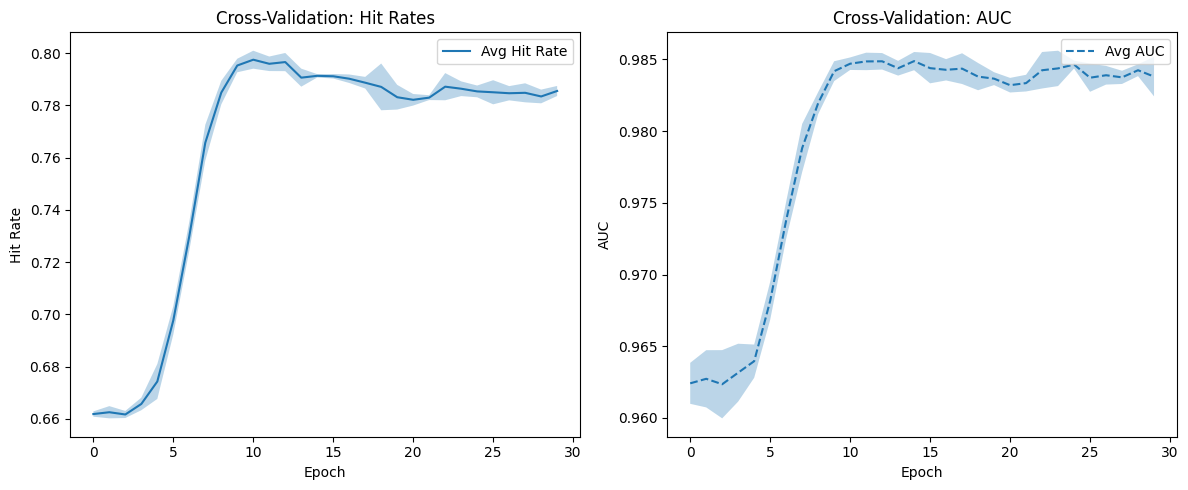

Cross-Validation Summary:
Final Hit Rate: 0.7855 ± 0.0019
Final AUC: 0.9838 ± 0.0014


In [17]:
def k_fold_cross_validation_recommender(df, num_users, num_items):
    """
   Performs k-fold cross validation for recommendation model training and evaluation.

   Args:
       df: Input dataframe containing user-item interactions
       num_users: Total number of unique users
       num_items: Total number of unique items

   Returns:
       dict: Results containing hit rates, AUC scores, and losses for each fold
  """
    kfold = KFold(n_splits=4, shuffle=True, random_state=42)
    # Dictionary to store metrics for all folds
    fold_results = {
        'hit_rates': [],
        'aucs': [],
        'losses': []
    }
    # Iterate through each fold
    for fold, (train_index, test_index) in enumerate(kfold.split(df), 1):
        print(f"FOLD {fold}")

        # Split data into train and validation sets
        train_data = df.iloc[train_index]
        val_data = df.iloc[test_index]

        # Process training data
        users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")

        # Process validation data
        users_val, items_val, ratings_val, val_iter = load_data(val_data, num_users, num_items, feedback="explicit")

        # Create training dataset and dataloader
        train_dataset = PRDataset(users_train, items_train, candidates, num_items)
        train_iter = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
        )

        # Initialize model for this fold
        net = NeuMF(num_factors= 512, num_users=num_users, num_items=num_items, nums_hiddens=[512, 256, 128, 64, 32, 16, 8, 4])
        net = net.to(device)

        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
        # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        class BPRLoss(nn.Module):
            def __init__(self):
                super(BPRLoss, self).__init__()

            def forward(self, pos_preds, neg_preds):
                return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

        loss_fn = BPRLoss()

        top_k = 5
        hit, auc, loss = train_ranking(
            net=net,
            train_iter=train_iter,
            test_iter=val_iter,
            loss_fn=loss_fn,
            optimizer=optimizer,
            test_seq_iter=None,
            num_users=num_users,
            num_items=num_items,
            num_epochs=num_epochs,
            device=device,
            candidates=candidates,
            batch_size=batch_size,
            top_k=top_k,
            evaluator=evaluate_ranking,
        )

        fold_results['hit_rates'].append(hit)
        fold_results['aucs'].append(auc)
        fold_results['losses'].append(loss)

    return fold_results

def analyze_cv_results(fold_results):
    """
   Analyzes and visualizes cross-validation results.

   Args:
       fold_results: Dictionary containing metrics from each fold
  """
  #  Calculate mean and standard deviation across folds
    avg_hit_rates = np.mean(fold_results['hit_rates'], axis=0)
    std_hit_rates = np.std(fold_results['hit_rates'], axis=0)

    avg_aucs = np.mean(fold_results['aucs'], axis=0)
    std_aucs = np.std(fold_results['aucs'], axis=0)

    # Create visualization
    plt.figure(figsize=(12, 5))

     # Plot Hit Rate
    plt.subplot(1, 2, 1)
    plt.plot(avg_hit_rates, label='Avg Hit Rate')
    plt.fill_between(
        range(len(avg_hit_rates)),
        avg_hit_rates - std_hit_rates,
        avg_hit_rates + std_hit_rates,
        alpha=0.3
    )
    plt.title('Cross-Validation: Hit Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Hit Rate')
    plt.legend()

    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(avg_aucs, label='Avg AUC', linestyle='--')
    plt.fill_between(
        range(len(avg_aucs)),
        avg_aucs - std_aucs,
        avg_aucs + std_aucs,
        alpha=0.3
    )
    plt.title('Cross-Validation: AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print final results with confidence intervals
    print("Cross-Validation Summary:")
    print(f"Final Hit Rate: {avg_hit_rates[-1]:.4f} ± {std_hit_rates[-1]:.4f}")
    print(f"Final AUC: {avg_aucs[-1]:.4f} ± {std_aucs[-1]:.4f}")

# Run cross-validation
df, num_users, num_items, item_original = read_data()
cv_results = k_fold_cross_validation_recommender(
    df,
    num_users,
    num_items,
)

analyze_cv_results(cv_results)

## Expermient

## 1. Best Model
Finding the best model out of the given models

While keeping the lr, weight_decay and batch size constant

In [18]:
# from tqdm.auto import tqdm
# def train_ranking(net, train_iter, test_iter, loss_fn, optimizer, test_seq_iter, num_users, num_items, num_epochs, device, evaluator,
#                   candidates, batch_size, top_k, eval_step=1):
#     """
#     Trains a ranking-based recommendation model using BPR loss.

#     Args:
#         net: The recommendation model to train
#         train_iter: Training data iterator (user, positive item, negative item)
#         test_iter: Test data for evaluation
#         loss_fn: Loss function (typically BPR loss)
#         optimizer: Optimizer for model parameters
#         test_seq_iter: Sequential data for testing (optional)
#         num_users: Total number of users
#         num_items: Total number of items
#         num_epochs: Number of training epochs
#         device: Device to run training on (CPU/GPU)
#         evaluator: Evaluation function
#         candidates: Dictionary of items each user has interacted with
#         batch_size: Batch size for evaluation
#         top_k: Number of top items for Hit Rate calculation
#         eval_step: Frequency of evaluation (epochs)

#     Returns:
#         tuple: Lists containing (hit_rates, auc_scores, training_losses)
#   """
#    # Initialize lists to track metrics
#     loss_l, hit_l, auc_l = [], [], []

#     # Training loop over epochs
#     for epoch in tqdm(range(num_epochs)):
#       # Initialize epoch statistics
#         total_loss, num_examples, num_batches = 0.0, 0, 0
#         # Set model to training mode
#         net.train()
#         for i, values in enumerate(train_iter):
#           # Move batch data to device
#             input_data = [v.to(device) for v in values]

#             # Clear gradients
#             optimizer.zero_grad()

#             # Forward pass for positive and negative items
#             p_pos = net(input_data[0], input_data[1])
#             p_neg = net(input_data[0], input_data[2])

#             # Calculate BPR loss
#             loss = loss_fn(p_pos, p_neg)

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             # Accumulate loss statistics
#             total_loss += loss.item() * input_data[0].size(0)
#             num_examples += input_data[0].size(0)
#             num_batches += 1
#         # scheduler.step()

#       # Evaluation phase
#         if (epoch + 1) % eval_step == 0:
#             net.eval()

#             # Evaluate model without gradient computation
#             with torch.no_grad():
#                 hit_rate, auc = evaluate_ranking(net, test_iter, test_seq_iter, candidates, num_users, num_items, device, batch_size, top_k)
#             print(f'Epoch {epoch + 1}, Hit Rate: {hit_rate:.3f}, AUC: {auc:.3f}', end = ' ')
#             hit_l.append(hit_rate)
#             auc_l.append(auc)
#             wandb.log({"hit": hit_rate, "auc": auc})
            

#         avg_loss = total_loss / num_examples
#         print(f'Training Loss: {avg_loss:.3f}', end='\n')
#         loss_l.append(avg_loss)
#         wandb.log({'loss': avg_loss})

#     return hit_l, auc_l, loss_l

In [19]:
# # Set batch size for training
# batch_size = 1024

# # Load and preprocess data
# df, num_users, num_items, item_original = read_data()
# train_data, test_data = split_data(df, 0.25)

# # Process training data
# users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")

# # Process test data
# users_test, items_test, ratings_test, test_iter = load_data(test_data, num_users, num_items, feedback="explicit")

# # Create dataset for personalized ranking
# train_dataset = PRDataset(users_train, items_train, candidates, num_items)

# # Create DataLoader with parallel data loading
# train_iter = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0 #os.cpu_count(),
# )

# # Initialize Neural Matrix Factorization model
# set_seeds()
# # net = NeuMF(num_factors= 2048, num_users=num_users, num_items=num_items, nums_hiddens=[2048, 1024, 512, 256, 128, 64, 32, 16])
# # print(net)
# # net = net.to(device)

# lr = 5e-3
# num_epochs = 30
# weight_decay = 1e-4

# # Initialize optimizer with Adam

# # Learning rate scheduler - reduce LR by 10x every 10 epochs
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# class BPRLoss(nn.Module):
#     """
#     Bayesian Personalized Ranking loss for implicit feedback.
#     Optimizes for correct ranking between positive and negative items.
#   """
#     def __init__(self):
#         super(BPRLoss, self).__init__()

#     def forward(self, pos_preds, neg_preds):
#         return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

# loss_fn = BPRLoss()

# # Login wandb
# wandb.login()

# # Train the model
# top_k = 5
# experiment_number = 0
# model_name = ["net_6_8", "net_6_16", "net_6_32", "net_8_2", "net_8_4", "net_8_8", "net_8_16", "net_8_32"] 

# for model in model_name:
#   wandb.init(
#       project='NueMFDysModel',
#       name=f'{model}',
#       config={
#           "epochs":num_epochs,
#           "batch_size": batch_size,
#           "lr":lr,
#           "weight_decay": weight_decay,
#           "model": model
#       }
#   )  

#   config = wandb.config
#   experiment_number += 1
#   if model == "net_6_8":
#     net = NeuMF(num_factors= 256, num_users=num_users, num_items=num_items, nums_hiddens=[256, 128, 64, 32, 16, 8])
#   elif model == "net_6_16":
#     net = NeuMF(num_factors= 512, num_users=num_users, num_items=num_items, nums_hiddens=[512, 256, 128, 64, 32, 16])
#   elif model == "net_6_32":
#     net = NeuMF(num_factors= 1024, num_users=num_users, num_items=num_items, nums_hiddens=[1024, 512, 256, 128, 64, 32])
#   elif model == "net_8_2":
#     net = NeuMF(num_factors= 256, num_users=num_users, num_items=num_items, nums_hiddens=[256, 128, 64, 32, 16, 8, 4, 2])
#   elif model == "net_8_4":
#     net = NeuMF(num_factors= 512, num_users=num_users, num_items=num_items, nums_hiddens=[512, 256, 128, 64, 32, 16, 8, 4])
#   elif model == "net_8_8":
#     net = NeuMF(num_factors= 1024, num_users=num_users, num_items=num_items, nums_hiddens=[1024, 512, 256, 128, 64, 32, 16, 8])
#   elif model == "net_8_16":
#     net = NeuMF(num_factors= 2048, num_users=num_users, num_items=num_items, nums_hiddens=[2048, 1024, 512, 256, 128, 64, 32, 16])
#   elif model == "net_8_32":
#     net = NeuMF(num_factors= 4096, num_users=num_users, num_items=num_items, nums_hiddens=[4096, 2048, 1024, 512, 256, 128, 64, 32])

#   net.to(device)
#   optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
#   hit, auc, loss= train_ranking(
#       net=net,
#       train_iter=train_iter,
#       test_iter=test_iter,
#       loss_fn=loss_fn,
#       optimizer=optimizer,
#       test_seq_iter=None,
#       num_users=num_users,
#       num_items=num_items,
#       num_epochs=num_epochs,
#       device=device,
#       candidates=candidates,
#       batch_size=batch_size,
#       top_k=top_k,
#       evaluator=evaluate_ranking,
#   )

#   print(f'Hit Rate@{top_k} is {hit[-1]:.3f} AUC is {auc[-1]:.3f}')
#   wandb.finish()

## 2. Hyperparameter optimization

In [20]:
# #wandb hpo
# sweep_config = {
#     'method': 'bayes'
# }

# metric = {
#     'name': 'loss',
#     'goal': 'minimize'
# }

# sweep_config['metric'] = metric

# parameters_dict = {
#     'batch_size':{
#         'values':[32, 64, 128, 256, 512, 1024, 2048]
#     }
# }

# sweep_config['parameters'] = parameters_dict

# parameters_dict.update({ 
#     'lr':{
#         'distribution': 'uniform',
#         'min':1e-4,
#         'max':1e-2
#     },
#     'weight_decay':{
#         'distribution': 'uniform',
#         'min':1e-5,
#         'max':1e-3
#     },
# })

# import pprint
# pprint.pprint(sweep_config)

# sweep_id = wandb.sweep(sweep_config, project='HPO')

In [21]:
# # Load and preprocess data
# df, num_users, num_items, item_original = read_data()
# train_data, test_data = split_data(df, 0.25)

# # Process training data
# users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")

# # Process test data
# users_test, items_test, ratings_test, test_iter = load_data(test_data, num_users, num_items, feedback="explicit")

# # Create dataset for personalized ranking
# train_dataset = PRDataset(users_train, items_train, candidates, num_items)

# # Create DataLoader with parallel data loading


# # Initialize Neural Matrix Factorization model
# set_seeds()
# # net = NeuMF(num_factors= 2048, num_users=num_users, num_items=num_items, nums_hiddens=[2048, 1024, 512, 256, 128, 64, 32, 16])
# # print(net)
# # net = net.to(device)

# # lr = 5e-3
# num_epochs = 30
# # weight_decay = 1e-4

# # Initialize optimizer with Adam

# # Learning rate scheduler - reduce LR by 10x every 10 epochs
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# class BPRLoss(nn.Module):
#     """
#     Bayesian Personalized Ranking loss for implicit feedback.
#     Optimizes for correct ranking between positive and negative items.
#   """
#     def __init__(self):
#         super(BPRLoss, self).__init__()

#     def forward(self, pos_preds, neg_preds):
#         return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

# loss_fn = BPRLoss()

# # Login wandb
# wandb.login()

# # Train the model
# top_k = 5 

# def train(config=None):
#     with wandb.init(config=config): 
#         config = wandb.config
#         net = NeuMF(num_factors= 512, num_users=num_users, num_items=num_items, nums_hiddens=[512, 256, 128, 64, 32, 16, 8, 4])
#         net.to(device)
#         optimizer = optim.Adam(net.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        
#         train_iter = DataLoader(
#             train_dataset,
#             batch_size=config.batch_size,
#             shuffle=True,
#             num_workers=0 #os.cpu_count(),
#         )  
        
#         hit, auc, loss = train_ranking(
#           net=net,
#           train_iter=train_iter,
#           test_iter=test_iter,
#           loss_fn=loss_fn,
#           optimizer=optimizer,
#           test_seq_iter=None,
#           num_users=num_users,
#           num_items=num_items,
#           num_epochs=num_epochs,
#           device=device,
#           candidates=candidates,
#           batch_size=config.batch_size,
#           top_k=top_k,
#           evaluator=evaluate_ranking,
#         )

In [22]:
# wandb.agent(sweep_id, train, count=100)

## END